### Meaning of each column:

**1) country:** The country that the wine is from.<br>
**2) description:** A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.<br>
**3) designation:** The vineyard within the winery where the grapes that made the wine are from.<br>
**4) points:** The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)<br>
**5) price:** The cost for a bottle of the wine. <br>
**6) province:** The province or state that the wine is from.<br>
**7) region_1:** The wine growing area in a province or state (ie Napa).<br>
**8) region_2:** Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.<br>
**9) variety:** The type of grapes used to make the wine (ie Pinot Noir). <br>
**10) winery:** The winery that made the wine. <br>


In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

**Load data + Train-test split:**

In [2]:
### Start from raw data:
# raw_data = utils.loadRawData()
# data = utils.cleanAndTransform(raw_data)
# utils.saveData(data)

### Start from processed data:
data = utils.loadCleanData('data/clean_v1.csv')

In [3]:
# I'm just gonna work with these columns:
M = data[['country', 'description', 'points', 'price', 'variety', 'clean_des']].values

# Train-test split:
X = M[:, -1]
Y = M[:, :-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [7]:
# # Transform to document-term matrix:
# # (Here I assume that the order of the words is not important. I want to use bag-of-word model.)
# def vectorize(words):
#     vec = CountVectorizer()
#     bow = vec.fit_transform(words)
#     return pd.DataFrame(bow.toarray(), columns=vec.get_feature_names())

# # Note that these matrix will be different. 
# # However, if we train the model properly, it should be robust to the variation between data points.
# Xv_train = vectorize(X_train)
# Xv_val = vectorize(X_val)
# Xv_test = vectorize(X_test)

## 1. Data visualization without "description": 

**I want to first look into how diverse the data are. Will there be some clusters in the feature space constructed by "country", "points", "price", "variety". I'm hoping to see the distribution of data points considering these four columns similar to that of the descriptions.**

1. country: one-hot-encoding
2. points: normalization
3. price: category
4. variety: one-hot-encoding

In [6]:
y_train = Y_train[:, [0,2,3,4]]
column_names = ['country', 'points', 'price', 'variety']

# COne-hot encode country:
for c in np.unique(y_train[:, 0]):
    y_train = np.append(y_train, np.reshape(np.array(y_train[:, 0]==c).astype(int), (-1, 1)), axis=1)
    column_names.append(c)
    
# Rescale points:
y_train = np.append(y_train, np.reshape(y_train[:, 1]/20, (-1, 1)), axis=1)
column_names.append('nor_points')

# Categorize price:
def categorize_price(value):
    if value < 22.0:
        return 1
    elif value < 33.0 and value >= 22.0:
        return 2
    elif value < 50.0 and value >= 33.0:
        return 3
    elif value < 80.0 and value >= 50.0:
        return 4
    else:
        return 5

vfunc = np.vectorize(categorize_price)
y_train = np.append(y_train, np.reshape(vfunc(y_train[:, 2]), (-1, 1)), axis=1)
column_names.append('cat_price')

In [5]:
# One-hot-encode variety:
for v in np.unique(y_train[:, 3]):
    y_train = np.append(y_train, np.reshape(np.array(y_train[:, 3]==v).astype(int), (-1, 1)), axis=1)
    column_names.append(v)

In [112]:
# # Drop the original four columns:
# y_train = y_train[:, 4:]
# column_names = column_names[4:]

In [7]:
pca = PCA(n_components=3)
pca_y_train = pca.fit_transform(y_train[:, 4:])

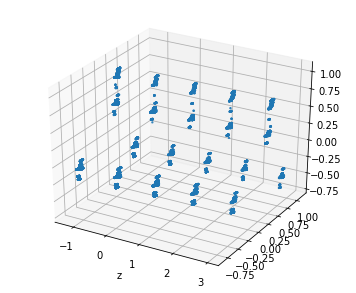

In [8]:
fig = plt.figure(figsize=[6, 5])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_y_train[:, 0], pca_y_train[:, 1], pca_y_train[:, 2], marker='o', s=2)
ax.set_xlabel('x')
ax.set_xlabel('y')
ax.set_xlabel('z')
plt.show()

Summary: It really looks like the data disperse base on their price category and country...

## 2. Look into "description":

### Goal: Find out the characters of different type of wine from the description.

### Step 1: Tokenization:

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create vectorizer:
# Only preserve words with freq=0.05~0.8
t_vec = TfidfVectorizer(max_df=0.8, min_df=0.05, max_features=20000, stop_words='english')

%time t_matrix = t_vec.fit_transform(X_train)

CPU times: user 2.28 s, sys: 67.2 ms, total: 2.35 s
Wall time: 2.35 s


In [34]:
words = t_vec.get_feature_names()
print('length=', len(words))
print(words)

length= 67
['acidity', 'apple', 'aromas', 'balanced', 'berry', 'bit', 'black', 'blackberry', 'blend', 'bodied', 'bright', 'cabernet', 'character', 'cherries', 'cherry', 'chocolate', 'citrus', 'clean', 'crisp', 'dark', 'drink', 'dry', 'fine', 'finish', 'firm', 'flavors', 'fresh', 'fruit', 'fruits', 'fruity', 'good', 'green', 'light', 'like', 'little', 'long', 'mouth', 'nose', 'notes', 'oak', 'offers', 'palate', 'peach', 'pepper', 'pinot', 'plum', 'raspberry', 'red', 'rich', 'ripe', 'sauvignon', 'shows', 'smooth', 'soft', 'spice', 'spicy', 'structure', 'style', 'sweet', 'tannic', 'tannins', 'texture', 'touch', 'vanilla', 'white', 'wine', 'years']


### Step 2: K-means clustering:

In [6]:
from sklearn.cluster import KMeans

In [35]:
n_clusters = 5
km = KMeans(n_clusters=n_clusters)

%time km.fit(t_matrix)
clusters = km.labels_.tolist()

CPU times: user 2min 50s, sys: 588 ms, total: 2min 51s
Wall time: 2min 43s


In [36]:
from sklearn.externals import joblib

joblib.dump(km,'data/cluster2_v1.pkl')
km = joblib.load('data/cluster2_v1.pkl')

In [37]:
clusters = km.labels_.tolist()

### Step 3: Include cluster in data:

In [38]:
reviews = {'country':Y_train[:, 0], 'points':Y_train[:, 2].astype(int), 'price':Y_train[:, 3].astype(float), 
          'variety':Y_train[:, -1], 'description':Y_train[:, 1], 'cluster':clusters}

df = pd.DataFrame(reviews, columns = ['country', 'points', 'price', 'variety', 'description', 'cluster'])

In [39]:
df.head(5)

,country,points,price,variety,description,cluster
0,Other,7,17.0,Cabernet Sauvignon,Boasts tremendously ripe fruit—the stated alco...,2
1,US,7,34.0,Cabernet Franc,"Ripe and smooth, with polished cherry pie fill...",0
2,France,10,25.0,Rosé,"This is a stylish wine, fruity with red curran...",2
3,Italy,13,85.0,Red Blend,This vintage has some Cabernet Sauvignon and P...,4
4,US,9,17.0,Merlot,"Aromatic and fruity, this is front-loaded with...",4


**Number of data points in each cluster:**

In [52]:
cluster_counts = df['cluster'].value_counts()
cluster_counts

1    27031
0    25312
2    22479
3    20587
4     7513
Name: cluster, dtype: int64

**Mean of points for each cluster:**

In [41]:
df['points'].groupby(df['cluster']).mean()

cluster
0    7.248933
1    7.688580
2    8.655278
3    7.189051
4    9.067350
Name: points, dtype: float64

**Mean of price for each cluster:**

In [42]:
df['price'].groupby(df['cluster']).mean()

cluster
0    33.129938
1    32.109208
2    40.037858
3    23.089523
4    43.984560
Name: price, dtype: float64

In [44]:
from __future__ import print_function

print("Top words for each cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters):
    print("Cluster {} words: ".format(i), end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(words[ind], end=', ')
    print() #add whitespace
    print() #add whitespace
    
print()

Top words for each cluster:

Cluster 0 words: flavors, dry, sweet, cherry, oak, wine, pinot, cherries, rich, drink, 

Cluster 1 words: aromas, palate, finish, fruit, cherry, berry, black, flavors, plum, nose, 

Cluster 2 words: wine, fruit, acidity, tannins, ripe, fruits, rich, flavors, years, red, 

Cluster 3 words: citrus, apple, peach, white, flavors, fresh, crisp, wine, green, finish, 

Cluster 4 words: cabernet, sauvignon, blend, tannins, wine, black, flavors, fruit, blackberry, cherry, 




**Some characters per cluster:**

Cluster 0: may has stronger flavor, rich, dry, may has smell of oak, cherry.

Cluster 1: may has stronger aromas (words: aromas, nose, finish)

Cluster 2: may taste acidity, tannins (contribute astringency and bitterness), ripe

Cluster 3: white wine, has a fresh taste (made with fruits including apple, citrus, peach)

Cluster 4: made with cabernet sauvignon (a kind of grape), has darker color (may made with balckberry, cherry)

Let's take a look if this makes sense:

In [69]:
def print_samples(cluster, n=4):
    print('Cluster {}:'.format(cluster))
    print()
    for i in range(n):
        print('Sample {}: {}'.format(i+1, df[df['cluster']==cluster].iloc[np.random.randint(cluster_counts.loc[cluster]), 4]))
        print()

In [72]:
print_samples(0, 3)

Cluster 0:

Sample 1: Lots of bright, savory raspberry, cherry, cola, vanilla, sandalwood and spice flavors in this drily delicious Pinot. It's so easy to enjoy glass after glass with a good steak or chop. Drink now for freshness.

Sample 2: A little reedy, with unripe mint flavors and some sharpness. Redeems itself on the midpalate with a hit of cherries and cola, then reprises the sharpness on the finish. Ready now.

Sample 3: This is a big, ripe, rich and oaky Chardonnay, the kind that will seduce lots of people with sheer dazzle, although only 135 cases were produced so it's likely to be hard to find. Dry and crisp, it's concentrated in pineapple tart and peach marmalade flavors, accented with plenty of sweet, smoky oak, and brightened with crisp Monterey acidity.



In [73]:
print_samples(1, 3)

Cluster 1:

Sample 1: Berry, red cherry and pepper start this lively rose from South Africa. Easydrinking and buoyant with a touch of Pinotage spice, the wine will pair well with heartier fish and meat dishes.

Sample 2: Crisp aromas and flavors of clove, mint, red berries and tobacco give this Shiraz a food-friendly but complex character. The minerally backbone, combined with the savory spicebox layers, offers Old World elegance with a South African twist. Ageable and a good pairing for grilled meats, filets.

Sample 3: Dark as night, with shoe polish, coconut and powerful black-fruit aromas. This is jammy, dense, soft and not for aging, but it does deliver a truck load of toasted coffee, blackberry, molasses and crisped brown sugar. Supersweet, rich and made to drink now.



In [74]:
print_samples(2, 3)

Cluster 2:

Sample 1: This is a beautiful, ripe, full-bodied sparkler, balancing rich fruit with bottle age to produce a round, elegant character. It is delicious to drink now, although there is enough fruit to allow it to age for 2–3 years.

Sample 2: Ame means the spirit, the soul, and Alain Rotier believes this wine expresses the true nature of his Gaillac estate. On that basis, it's a place of great perfumes, coming through in the wine from wood as well as chunky black fruits. It is a relatively soft wine, the concentration in the dense fruit rather than the tannins.

Sample 3: Although this hearty Amarone delivers a whopping 17% alcohol, the heat and power is well integrated within the wine's juicy berry fiber and spicy aromas of clove and pepper. Pair this wine with thick pasta and creamy blue cheese sauce.



In [75]:
print_samples(3, 3)

Cluster 3:

Sample 1: Fruit from the oldest blocks in this pioneering vineyard is sourced here. It's bright, spicy and focused, with forward citrus-scented Bing cherry flavors. The concentration and length are outstanding, with just the lightest suggestion of green herbs rounding out the finish.

Sample 2: A fine, copper- colored blush with intricate flavors of raspberries, rosehip tea, peach and cinnamon spice. Goes beyond simple rosé-ness to achieve complexity.

Sample 3: Great price for this unoaked white wine. It's smooth and crisp in mouthwatering acidity, with ripe flavors of citrus fruits, lemongrass, minerals and vanilla that finish with a honeyed richness. Easy to find, with production of 21,696 cases.

